# 1. Extract, visualize and load data

ít data,
pretrained model sẽ cho kq tốt hơn,

Task to do: CNN and ViT to compare result (both are fine-tuned)




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q '/content/drive/MyDrive/AISIA/AERA02_AptitudeAssessment_Dataset_CV.zip' -d '/content'

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict

In [4]:
data_dir = '/content/AISIA_BOUTIQUE_DATASET'

categories = []
category_mapping = dict()

img_dirs = []
imgs_cnts = []

for category in os.listdir(data_dir):
    category_dir = os.path.join(data_dir, category)
    if os.path.isdir(category_dir):
        categories.append(category)
        category_mapping[category] = len(categories)
        imgs_cnt = 0

        for img in os.listdir(category_dir):

            if img[:3] != 'img': #remove .DS files
                continue

            img_dir = os.path.join(category, img)
            img_dirs.append([img_dir, category])
            imgs_cnt += 1
        print(f"Number of images of category {category}:", imgs_cnt)
        imgs_cnts.append(imgs_cnt)

print("Total number of images:", len(img_dirs))

Number of images of category polo_shirts: 9
Number of images of category men_coats: 16
Number of images of category dresses: 299
Number of images of category women_tshirts: 299
Number of images of category men_trousers: 599
Number of images of category women_pants: 298
Number of images of category men_sweaters: 300
Number of images of category tanks: 8
Number of images of category women_coats: 300
Number of images of category cardigans: 299
Number of images of category women_sweaters: 300
Total number of images: 2727


In [5]:
df = pd.DataFrame(img_dirs, columns = ['img_path', 'category'])
df.head()

,img_path,category
0,polo_shirts/img_10785767.jpg,polo_shirts
1,polo_shirts/img_10759617.jpg,polo_shirts
2,polo_shirts/img_11785985.jpg,polo_shirts
3,polo_shirts/img_11872544.jpg,polo_shirts
4,polo_shirts/img_2118885.jpg,polo_shirts


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2)

print(len(train_df), len(val_df))

2181 546


<Axes: >

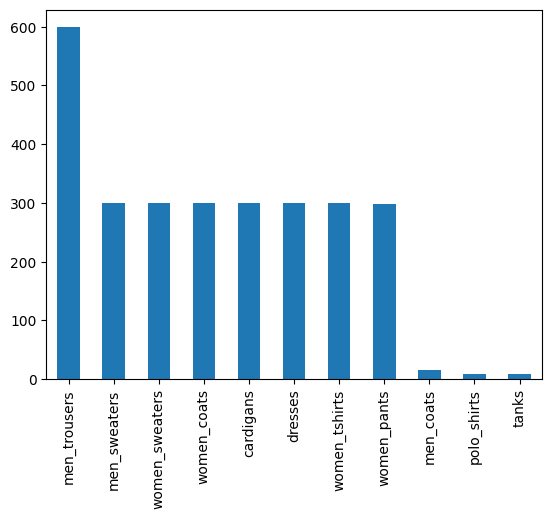

In [7]:
df['category'].value_counts().plot(kind='bar')

<Axes: >

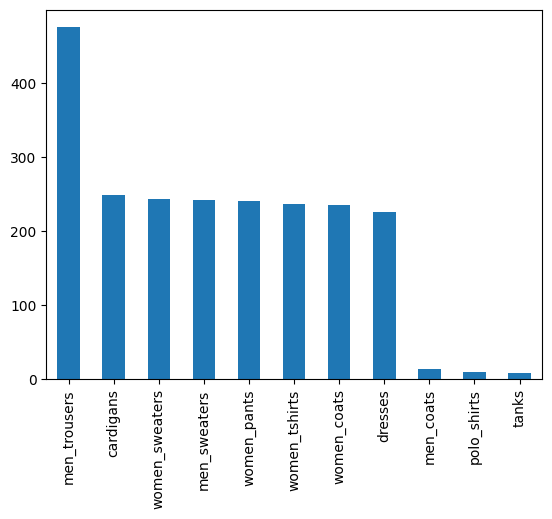

In [8]:
train_df['category'].value_counts().plot(kind='bar')

<Axes: >

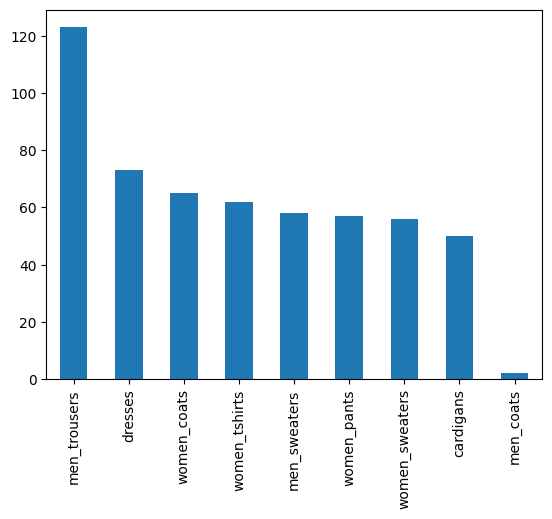

In [9]:
val_df['category'].value_counts().plot(kind='bar')

In [10]:
import os
from PIL import Image
import shutil

def create_dataset_directory(df, data_dir, root_dir = '/content/AISIA_BOUTIQUE_DATASET'):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for id in df.index:
        img_path, category = df['img_path'][id], df['category'][id]
        category_dir = os.path.join(data_dir, category)
        if not os.path.exists(category_dir):
            os.makedirs(category_dir)

        image = Image.open(os.path.join(root_dir, img_path))
        if image.mode in ("RGBA", "P"): #some images have 4 dimension
            image = image.convert("RGB")
        image_dir = os.path.join(data_dir, img_path)
        image.save(image_dir)
if os.path.exists('/content/dataset'):
    shutil.rmtree('/content/dataset') #for block re-run
create_dataset_directory(train_df, data_dir = '/content/dataset/train')
create_dataset_directory(train_df, data_dir = '/content/dataset/val')

#  2. Data loading

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [12]:
train_composer = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_composer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_transforms = {
    'train': train_composer,
    'val': val_composer
}

data_dir = '/content/dataset'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            data_transforms[x]) for x in ['train', 'val']}

data_loaders = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size = 4,
                                   shuffle = True,
                                   num_workers = 4) for x in ['train', 'val']}

dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

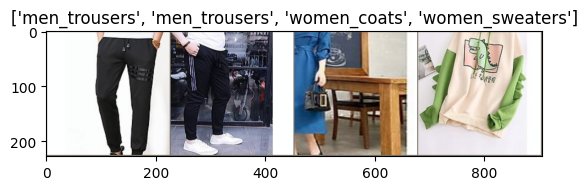

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(data_loaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 3.1 Model fine-tuning (resnet-18)


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in data_loaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                if phase == 'val':
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, train_accs, val_losses, val_accs

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr = 0.001, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

n_epochs = 50

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 100MB/s]


In [ ]:
#train the model
#don't run this block if the model was trained
model_ft, train_losses, train_accs, val_losses, val_accs = train_model(model_ft,
                                                                       criterion,
                                                                       optimizer_ft,
                                                                       exp_lr_scheduler,
                                                                       num_epochs = n_epochs)
weight_path = '/content/drive/MyDrive/AISIA/model.pth'
torch.save(model_ft, weight_path)

Epoch 1/50
----------
train Loss: 1.8634 Acc: 0.3663
val Loss: 1.2115 Acc: 0.5883
Epoch 2/50
----------
train Loss: 1.7519 Acc: 0.4058
val Loss: 1.0851 Acc: 0.6323
Epoch 3/50
----------
train Loss: 1.5402 Acc: 0.4723
val Loss: 1.0806 Acc: 0.6387
Epoch 4/50
----------


In [ ]:
def metric_visualize(x, y1, y2, legend_arr, title):
    plt.plot(x, y1)
    plt.plot(x, y2)
    plt.xlabel("Loss")
    plt.ylabel("Epoch")
    plt.legend(legend_arr, loc="upper right")
    plt.title('Training and validation losses')
    plt.show()

In [ ]:
n_epochs = 50
metric_visualize(x = np.arange(n_epochs),
                 y1 = train_losses,
                 y2 = val_losses,
                 legend_arr = ['Training loss', 'Validation loss'],
                 title = 'Training and validation losses')

In [ ]:
n_epochs = 50
train_accs = [x.item() for x in train_accs]
val_accs = [x.item() for x in val_accs]
metric_visualize(x = np.arange(n_epochs),
                 y1 = train_accs,
                 y2 = val_accs,
                 legend_arr = ['Training accuracy', 'Validation accuracy'],
                 title = 'Training and validation accuracy')

# 3.2 Load model weight (resnet-18)


In [14]:
#load the model
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

weight_path = '/content/drive/MyDrive/AISIA/model.pth'
model_ft = torch.load(weight_path)
model_ft.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 3.3 Evaluate model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]} gt: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

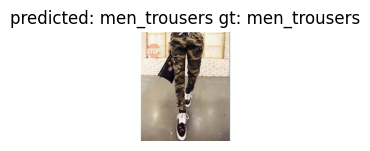

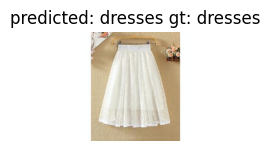

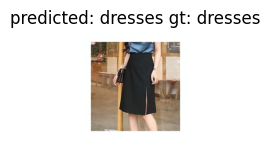

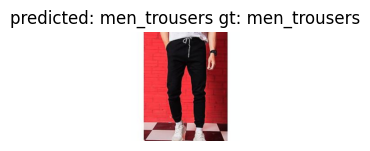

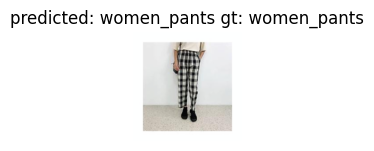

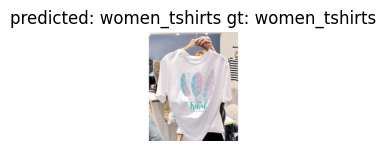

In [16]:
visualize_model(model_ft)

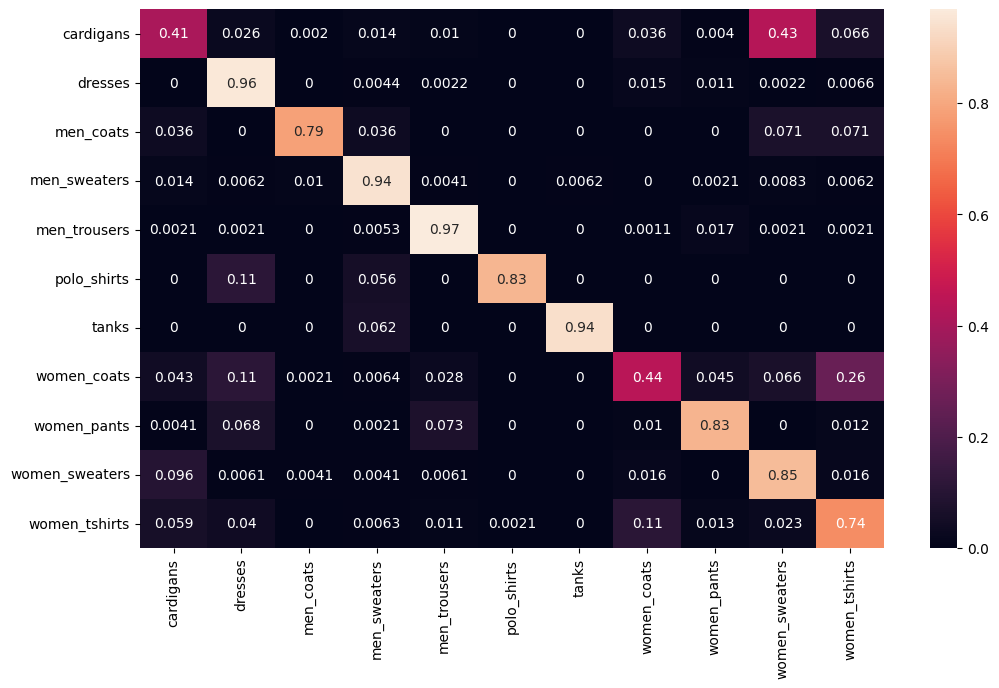

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
input_imgs = []

full_data_loader = [d for dl in [data_loaders['train'], data_loaders['val']] for d in dl]

with torch.no_grad():
    for inputs, labels in full_data_loader:
            input_imgs.extend(inputs)
            output = model_ft(inputs.cuda())

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/content/drive/MyDrive/AISIA/output.png')

# 3.4 Feature extraction (Resnet-18)

In [18]:
feature_extractor = torch.nn.Sequential(*list(model_ft.children())[:-1])
x = torch.randn([1,3,224,224]).cuda()
output = feature_extractor(x)
print(output.squeeze().shape)

torch.Size([512])


In [19]:
data_dir = '/content/AISIA_BOUTIQUE_DATASET'

torch.cuda.empty_cache()
image_embeddings = []
with torch.no_grad():
    for id in df.index:
        img_path = os.path.join(data_dir, df['img_path'][id])
        img = Image.open(img_path).convert('RGB')
        img = torch.unsqueeze(val_composer(img).cuda(), 0)
        image_embedding = feature_extractor(img).squeeze().cpu().numpy()
        image_embeddings.append(image_embedding)

df_embs_resnet18 = df.assign(embedding = image_embeddings)
df_embs_resnet18.head()

,img_path,category,embedding
0,polo_shirts/img_10785767.jpg,polo_shirts,"[1.7756625, 0.0027416965, 0.5782645, 1.516868,..."
1,polo_shirts/img_10759617.jpg,polo_shirts,"[3.7447898, 0.001612425, 1.0397842, 1.291319, ..."
2,polo_shirts/img_11785985.jpg,polo_shirts,"[3.4014359, 0.017269628, 0.5550445, 2.1857111,..."
3,polo_shirts/img_11872544.jpg,polo_shirts,"[0.5001363, 0.2021623, 0.3898917, 0.646072, 0...."
4,polo_shirts/img_2118885.jpg,polo_shirts,"[3.3838534, 0.030290661, 0.61069906, 1.6747819..."


# 4. Pretrained model (Fashion-clip, based on ViT-B/32)


In [20]:
!pip install -q fashion-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731

In [21]:
from fashion_clip.fashion_clip import FashionCLIP
import os
import numpy as np
from PIL import Image

fclip = FashionCLIP('fashion-clip')

imgs = []

data_dir = '/content/AISIA_BOUTIQUE_DATASET'

for id in df.index:
    img_path = os.path.join(data_dir, df['img_path'][id])
    img = Image.open(img_path)
    imgs.append(img)

img_embs = fclip.encode_images(imgs, batch_size=32).tolist()
df_embs_fclip = df.assign(embedding = img_embs)
df_embs_fclip.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

86it [00:32,  2.66it/s]


,img_path,category,embedding
0,polo_shirts/img_10785767.jpg,polo_shirts,"[0.00902228057384491, -1.0692338943481445, -1...."
1,polo_shirts/img_10759617.jpg,polo_shirts,"[-0.026532568037509918, -0.6414022445678711, -..."
2,polo_shirts/img_11785985.jpg,polo_shirts,"[0.027116328477859497, -0.4781404435634613, -0..."
3,polo_shirts/img_11872544.jpg,polo_shirts,"[0.11652493476867676, -0.8176167011260986, -1...."
4,polo_shirts/img_2118885.jpg,polo_shirts,"[0.2858160138130188, -0.9486654996871948, -0.4..."


# 5. Recommendation

In [22]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy.linalg import norm
import random

def cossim(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

def get_k_most_similar_items(input_emb, base_id, df, k = 10):
    scores = []
    for id in df.index:
        if id == base_id:
            continue
        emb = df['embedding'][id]
        score = cossim(input_emb, emb)
        scores.append([score, id])
    scores = sorted(scores, key = lambda x: -x[0])
    return scores[:10]

def get_recommendation(input_id, df, visualize = True):
    data_dir = '/content/AISIA_BOUTIQUE_DATASET'
    base_img_path = os.path.join(data_dir, df['img_path'][input_id])
    base_img_embs = df['embedding'][input_id]
    base_img = Image.open(base_img_path)

    top_10_similar = get_k_most_similar_items(base_img_embs, input_id, df)

    if visualize:
        image_data_list = [base_img]
        title_list = ['Input image']
        for i, item in enumerate(top_10_similar):
            score, item_id = item
            rounded_score = round(score, 3)
            item_img_path = os.path.join(data_dir, df['img_path'][item_id])
            item_img = Image.open(item_img_path)
            image_data_list.append(item_img)
            title_list.append(f'Top {i + 1} item ' + f'| Score: {str(rounded_score)}')

        num_rows = 2
        num_cols = 6

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))

        flat_axes = axes.flatten()

        for i, image_data in enumerate(image_data_list):
            if i < len(flat_axes):
                ax = flat_axes[i]
                ax.imshow(image_data)
                ax.axis('off')
                ax.set_title(title_list[i])

        for i in range(len(image_data_list), len(flat_axes)):
            flat_axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        relevant_score = 0 #same category as input
        for id, item in enumerate(top_10_similar):
            score, item_id = item
            relevant_score += 0 if df['category'][input_id] != df['category'][item_id] else 1
        return relevant_score

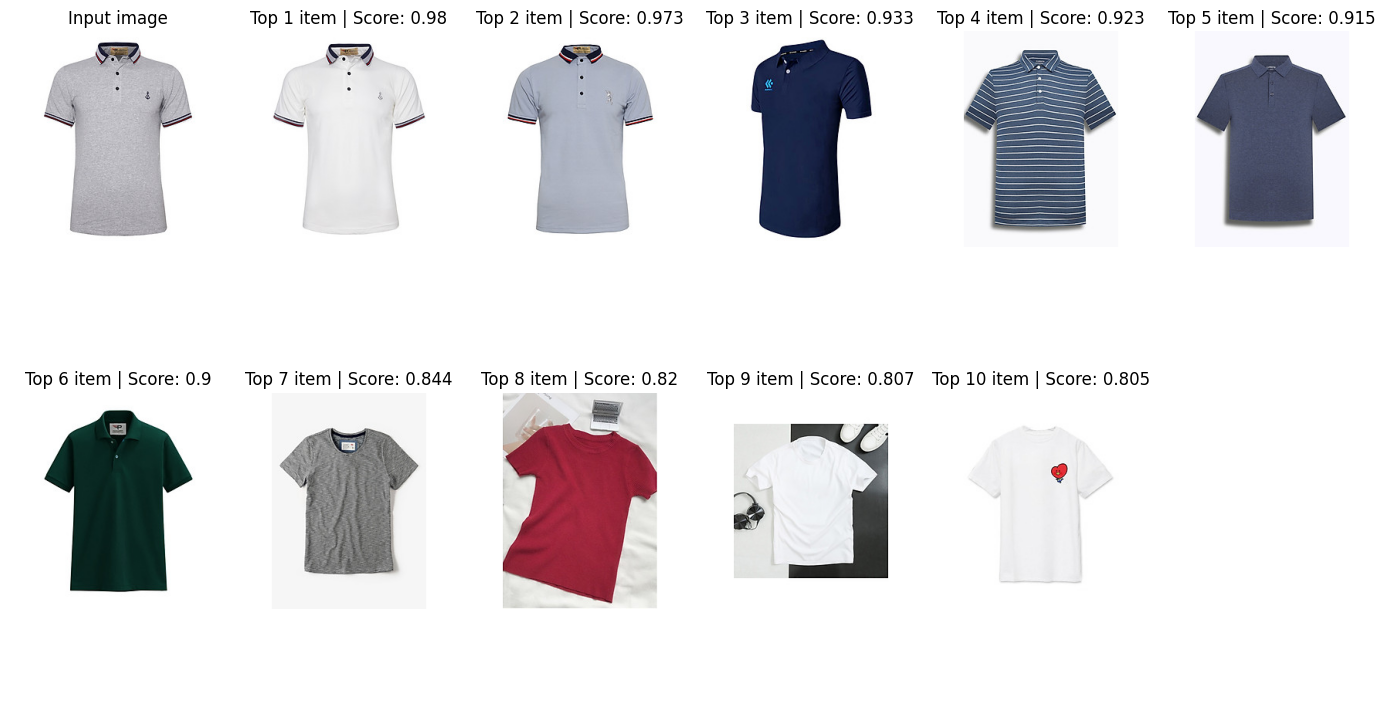

In [23]:
item_id = 0 # fixed query
# item_id = random.randint(0, len(df_embs_resnet18.index))
get_recommendation(item_id, df_embs_resnet18)

In [27]:
import time

n_trials = 1000
resnet18_score = 0

st = time.time()
for _ in range(n_trials):
    item_id = random.randint(0, len(df_embs_resnet18.index) - 1)
    resnet18_score += get_recommendation(item_id, df_embs_resnet18, visualize = False)

ed = time.time()
print(f"Relevant score: {resnet18_score / n_trials}")
print(f'Total time (s): {(ed - st) / n_trials}')

Relevant score: 7.327
Total time (s): 0.04386180591583252


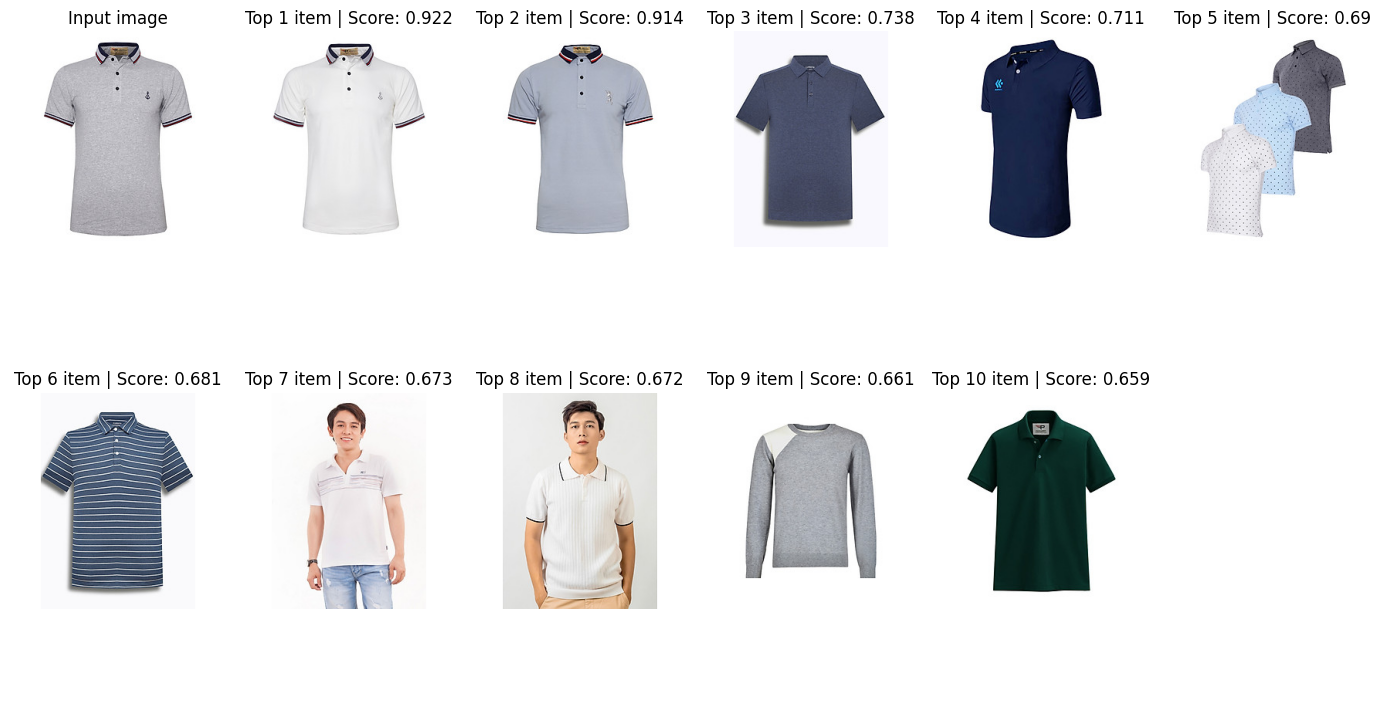

In [25]:
item_id = 0 # fixed query
# item_id = random.randint(0, len(df_embs.index))
get_recommendation(item_id, df_embs_fclip)

In [29]:
n_trials = 1000

total_time = 0
fclip_score = 0

st = time.time()
for _ in range(n_trials):
    item_id = random.randint(0, len(df_embs_fclip.index) - 1)
    fclip_score += get_recommendation(item_id, df_embs_fclip, visualize = False)

ed = time.time()
print(f"Relevant score: {fclip_score / n_trials}")
print(f'Total time (s): {(ed - st) / n_trials}')

Relevant score: 7.293
Total time (s): 0.40587974977493285


In [30]:
print(df_embs_resnet18.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2727 entries, 0 to 2726
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   2727 non-null   object
 1   category   2727 non-null   object
 2   embedding  2727 non-null   object
dtypes: object(3)
memory usage: 64.0+ KB
None


In [31]:
print(df_embs_fclip.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2727 entries, 0 to 2726
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   2727 non-null   object
 1   category   2727 non-null   object
 2   embedding  2727 non-null   object
dtypes: object(3)
memory usage: 64.0+ KB
None
